<a href="https://colab.research.google.com/github/joelma78/GitPY/blob/main/EntregaAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [17]:



try:
    # Ler o arquivo CSV para um DataFrame
    df_completo = pd.read_csv('/content/sample_data/dados_amazonas_logistica.csv')
    print("\nDataset 'dados_amazonas_logistica.csv' carregado com sucesso!")
    print("As primeiras 5 linhas do DataFrame carregado são:")
    display(df_completo.head())

    # Calcular tempos de entrega (função mantida para compatibilidade, mas os valores
    # já estarão no CSV se ele foi gerado a partir do notebook original)

    def calcular_tempo_entrega(distancia, acesso_rodovia, acesso_fluvial, regiao, servico):
        tempo_base = distancia / 100
        if acesso_rodovia:
            tempo_base *= 0.8
        elif acesso_fluvial:
            tempo_base *= 1.2
        if regiao in ['Alto Solimões', 'Vale do Juruá']:
            tempo_base *= 1.3
        elif regiao == 'Metropolitana':
            tempo_base *= 0.7
        if servico == 'PAC':
            tempo_base += 3
        else:
            tempo_base += 1
        tempo_final = max(2, round(tempo_base))
        return tempo_final

    # Recalcular (ou apenas verificar se as colunas existem) para garantir consistência
    if 'tempo_entrega_pac' not in df_completo.columns:
        df_completo['tempo_entrega_pac'] = df_completo.apply(
            lambda x: calcular_tempo_entrega(x['distancia_manaus_km'], x['acesso_rodovia'],
                                           x['acesso_fluvial'], x['regiao'], 'PAC'), axis=1
        )
    if 'tempo_entrega_sedex' not in df_completo.columns:
        df_completo['tempo_entrega_sedex'] = df_completo.apply(
            lambda x: calcular_tempo_entrega(x['distancia_manaus_km'], x['acesso_rodovia'],
                                           x['acesso_fluvial'], x['regiao'], 'SEDEX'), axis=1
        )
    if 'diferenca_pac_sedex' not in df_completo.columns:
        df_completo['diferenca_pac_sedex'] = df_completo['tempo_entrega_pac'] - df_completo['tempo_entrega_sedex']

    print("\n DATASET COMPLETO DO AMAZONAS")
    print("="*50)
    print(f"Total de municípios: {len(df_completo)}")
    print(f"Colunas: {df_completo.columns.tolist()}")
    print(f"\nDimensões: {df_completo.shape}")

    print("\n ESTATÍSTICAS GERAIS:")
    print(df_completo[['distancia_manaus_km', 'tempo_entrega_pac', 'tempo_entrega_sedex']].describe())

    print(f"\n CORRELAÇÕES:")
    print(f"Distância vs PAC: {df_completo['distancia_manaus_km'].corr(df_completo['tempo_entrega_pac']):.3f}")
    print(f"Distância vs SEDEX: {df_completo['distancia_manaus_km'].corr(df_completo['tempo_entrega_sedex']):.3f}")
except FileNotFoundError:
    print("\nO arquivo 'dados_amazonas_logistica.csv' não foi encontrado entre os uploads. Por favor, tente novamente.")


Dataset 'dados_amazonas_logistica.csv' carregado com sucesso!
As primeiras 5 linhas do DataFrame carregado são:


,municipio,distancia_manaus_km,populacao,acesso_rodovia,acesso_fluvial,regiao,tempo_entrega_pac,tempo_entrega_sedex,diferenca_pac_sedex,eficiencia_pac,cluster_logistica
0,Alvarães,540,15823,0,1,Centro,9,7,2,60.000000,0
1,Amaturá,880,11557,0,1,Alto Solimões,17,15,2,51.764706,3
2,Anamã,132,12056,0,1,Centro,5,3,2,26.400000,2
3,Anori,168,21767,0,1,Centro,5,3,2,33.600000,2
4,Apuí,408,21563,0,1,Sul,8,6,2,51.000000,2



 DATASET COMPLETO DO AMAZONAS
Total de municípios: 62
Colunas: ['municipio', 'distancia_manaus_km', 'populacao', 'acesso_rodovia', 'acesso_fluvial', 'regiao', 'tempo_entrega_pac', 'tempo_entrega_sedex', 'diferenca_pac_sedex', 'eficiencia_pac', 'cluster_logistica']

Dimensões: (62, 11)

 ESTATÍSTICAS GERAIS:
       distancia_manaus_km  tempo_entrega_pac  tempo_entrega_sedex
count            62.000000          62.000000            62.000000
mean            469.000000           9.258065             7.354839
std             364.029228           5.897861             5.800217
min               0.000000           3.000000             2.000000
25%             176.000000           5.000000             3.000000
50%             356.500000           7.000000             5.000000
75%             766.500000          12.750000            10.750000
max            1280.000000          23.000000            21.000000

 CORRELAÇÕES:
Distância vs PAC: 0.986
Distância vs SEDEX: 0.982


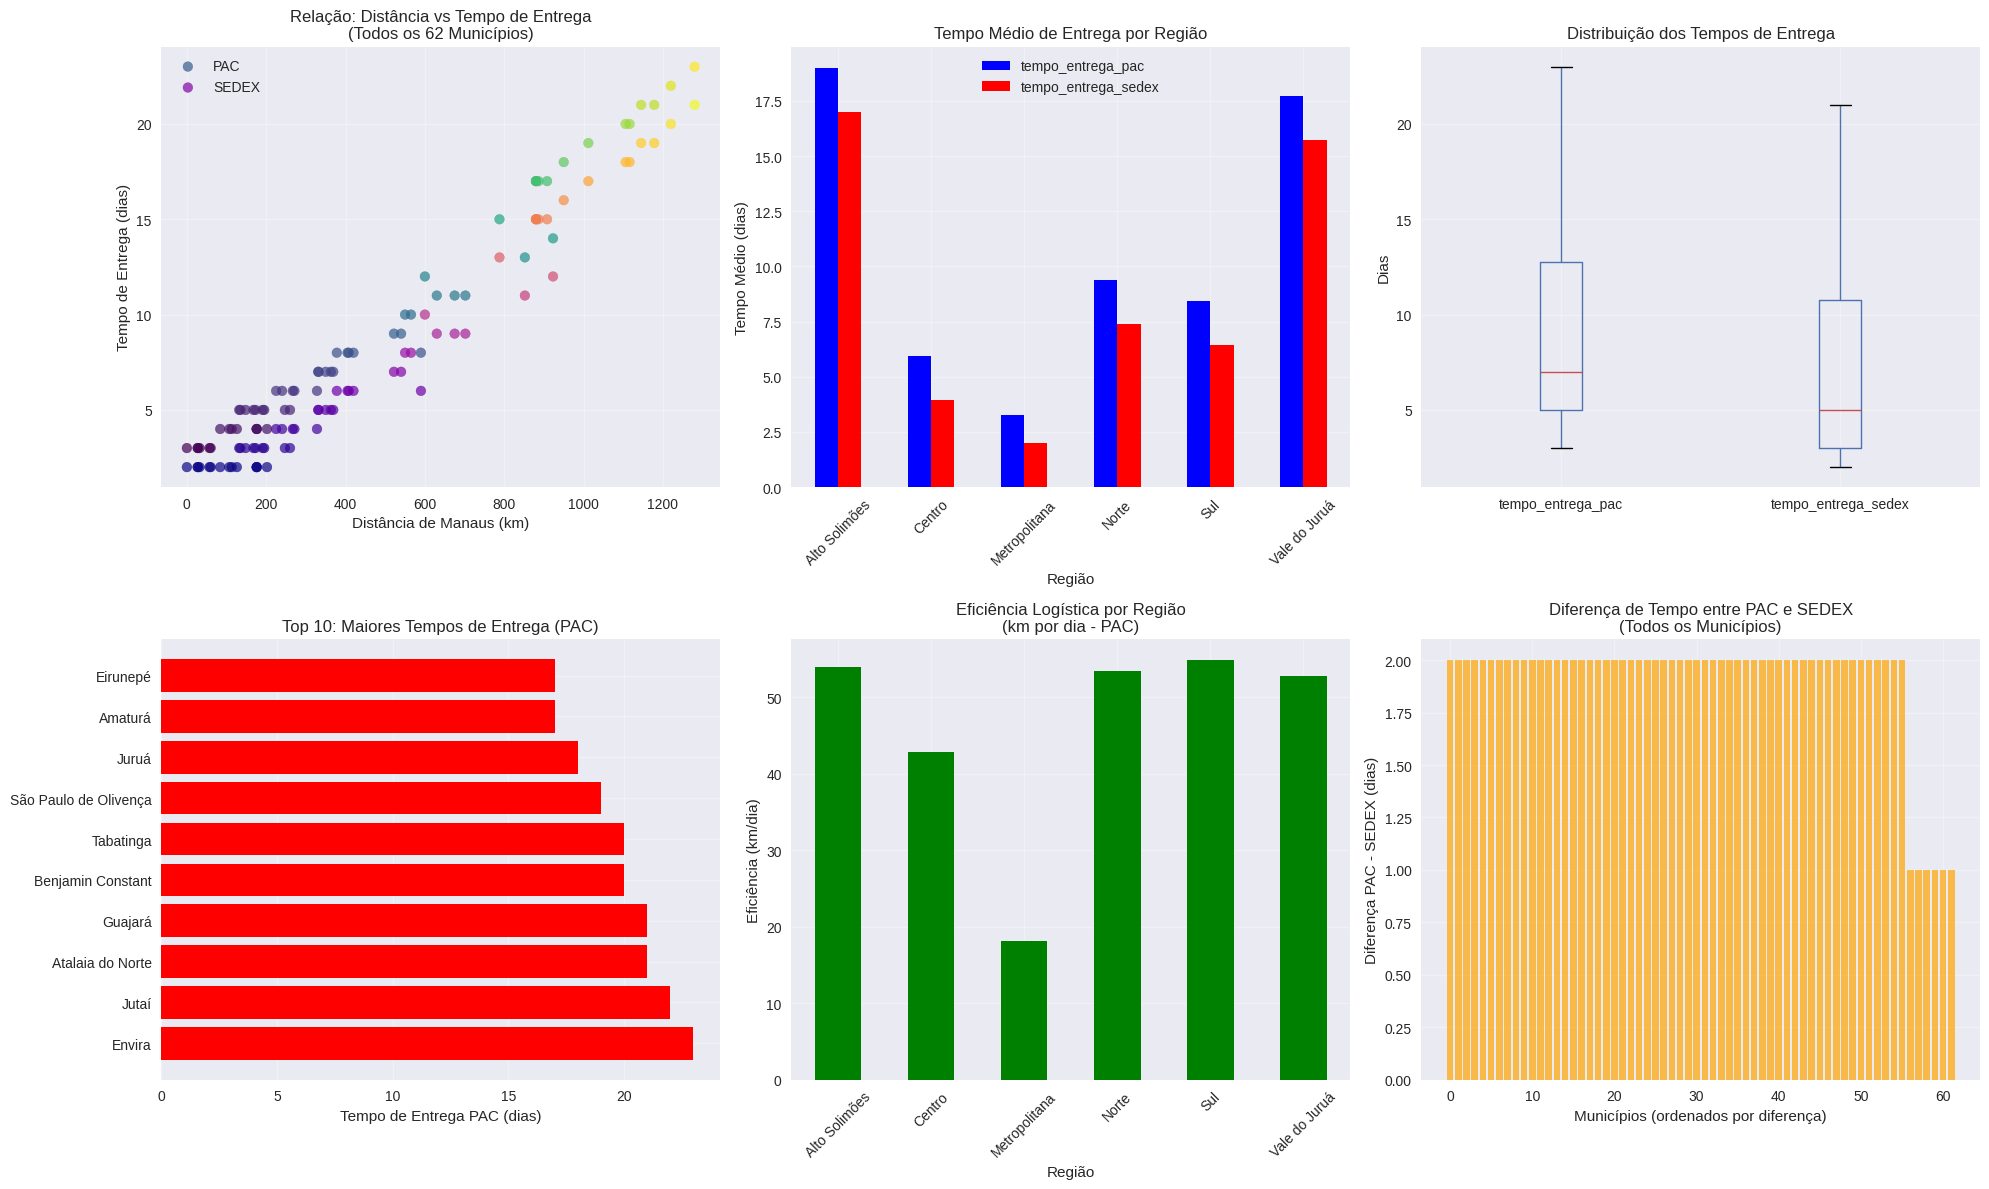

In [18]:
# Configuração de visualização
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Gráfico 1: Tempo de entrega vs Distância
scatter1 = axes[0,0].scatter(df_completo['distancia_manaus_km'], df_completo['tempo_entrega_pac'],
                            c=df_completo['tempo_entrega_pac'], cmap='viridis', alpha=0.7, label='PAC')
scatter2 = axes[0,0].scatter(df_completo['distancia_manaus_km'], df_completo['tempo_entrega_sedex'],
                            c=df_completo['tempo_entrega_sedex'], cmap='plasma', alpha=0.7, label='SEDEX')
axes[0,0].set_xlabel('Distância de Manaus (km)')
axes[0,0].set_ylabel('Tempo de Entrega (dias)')
axes[0,0].set_title('Relação: Distância vs Tempo de Entrega\n(Todos os 62 Municípios)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Tempo médio por região
tempo_por_regiao = df_completo.groupby('regiao')[['tempo_entrega_pac', 'tempo_entrega_sedex']].mean()
tempo_por_regiao.plot(kind='bar', ax=axes[0,1], color=['blue', 'red'])
axes[0,1].set_title('Tempo Médio de Entrega por Região')
axes[0,1].set_xlabel('Região')
axes[0,1].set_ylabel('Tempo Médio (dias)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Distribuição dos tempos de entrega
df_completo[['tempo_entrega_pac', 'tempo_entrega_sedex']].boxplot(ax=axes[0,2])
axes[0,2].set_title('Distribuição dos Tempos de Entrega')
axes[0,2].set_ylabel('Dias')
axes[0,2].grid(True, alpha=0.3)

# Gráfico 4: Top 10 municípios com maior tempo de entrega (PAC)
top_lentos = df_completo.nlargest(10, 'tempo_entrega_pac')[['municipio', 'tempo_entrega_pac', 'regiao']]
axes[1,0].barh(top_lentos['municipio'], top_lentos['tempo_entrega_pac'],
               color=['red' if reg in ['Alto Solimões', 'Vale do Juruá'] else 'blue'
                      for reg in top_lentos['regiao']])
axes[1,0].set_xlabel('Tempo de Entrega PAC (dias)')
axes[1,0].set_title('Top 10: Maiores Tempos de Entrega (PAC)')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 5: Eficiência por região
df_completo['eficiencia_pac'] = df_completo['distancia_manaus_km'] / df_completo['tempo_entrega_pac']
eficiencia_regiao = df_completo.groupby('regiao')['eficiencia_pac'].mean()
eficiencia_regiao.plot(kind='bar', ax=axes[1,1], color='green')
axes[1,1].set_title('Eficiência Logística por Região\n(km por dia - PAC)')
axes[1,1].set_xlabel('Região')
axes[1,1].set_ylabel('Eficiência (km/dia)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Gráfico 6: Diferença PAC vs SEDEX por município
df_completo_sorted = df_completo.sort_values('diferenca_pac_sedex', ascending=False)
axes[1,2].bar(range(len(df_completo_sorted)), df_completo_sorted['diferenca_pac_sedex'],
              color='orange', alpha=0.7)
axes[1,2].set_xlabel('Municípios (ordenados por diferença)')
axes[1,2].set_ylabel('Diferença PAC - SEDEX (dias)')
axes[1,2].set_title('Diferença de Tempo entre PAC e SEDEX\n(Todos os Municípios)')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
#Criando o modelo preditivo com todos os municípios
# Preparar dados para machine learning
df_ml = df_completo.copy()

if 'month' not in df_ml.columns:
    df_ml['month'] = np.random.randint(1, 13, len(df_ml))
if 'estacao_anual' not in df_ml.columns:

    meses_cheia = [3, 4, 5, 6]
    meses_varzea = [9, 10, 11]
    def get_estacao(month):
        if month in meses_cheia:
            return 'Cheia'
        elif month in meses_varzea:
            return 'Várzea'
        else:
            return 'Normal'
    df_ml['estacao_anual'] = df_ml['month'].apply(get_estacao)

# Codificar variáveis categóricas
regiao_mapping = {'Metropolitana': 0, 'Centro': 1, 'Sul': 2, 'Norte': 3, 'Alto Solimões': 4, 'Vale do Juruá': 5}
df_ml['regiao_encoded'] = df_ml['regiao'].map(regiao_mapping)

# Aplicar One-Hot Encoding para
df_ml = pd.get_dummies(df_ml, columns=['estacao_anual'], prefix='estacao_anual', drop_first=False)

# Features e target
features_seasonal = ['distancia_manaus_km', 'populacao', 'acesso_rodovia', 'acesso_fluvial', 'regiao_encoded',
                     'estacao_anual_Cheia', 'estacao_anual_Normal', 'estacao_anual_Várzea'] # Usar features atualizadas
X = df_ml[features_seasonal] # Usar features atualizadas
y_pac = df_ml['tempo_entrega_pac']
y_sedex = df_ml['tempo_entrega_sedex']

# Dividir dados
X_train, X_test, y_pac_train, y_pac_test = train_test_split(X, y_pac, test_size=0.2, random_state=42)
_, _, y_sedex_train, y_sedex_test = train_test_split(X, y_sedex, test_size=0.2, random_state=42)

# Treinar modelos
model_pac_seasonal = RandomForestRegressor(n_estimators=100, random_state=42)
model_pac_seasonal.fit(X_train, y_pac_train)

model_sedex_seasonal = RandomForestRegressor(n_estimators=100, random_state=42)
model_sedex_seasonal.fit(X_train, y_sedex_train)

# Avaliar modelos
y_pac_pred = model_pac_seasonal.predict(X_test)
y_sedex_pred = model_sedex_seasonal.predict(X_test)

print(" MODELOS PREDITIVOS - TODOS OS MUNICÍPIOS (COM SAZONALIDADE)") # Título atualizado
print("="*50)
print(f" Modelo PAC - MAE: {mean_absolute_error(y_pac_test, y_pac_pred):.2f} dias")
print(f" Modelo PAC - R²: {r2_score(y_pac_test, y_pac_pred):.3f}")
print(f" Modelo SEDEX - MAE: {mean_absolute_error(y_sedex_test, y_sedex_pred):.2f} dias")
print(f" Modelo SEDEX - R²: {r2_score(y_sedex_test, y_sedex_pred):.3f}")

print(f"\n IMPORTÂNCIA DAS VARIÁVEIS (PAC):")
importancias = pd.DataFrame({
    'feature': features_seasonal,
    'importancia': model_pac_seasonal.feature_importances_
}).sort_values('importancia', ascending=False)
print(importancias)

 MODELOS PREDITIVOS - TODOS OS MUNICÍPIOS (COM SAZONALIDADE)
 Modelo PAC - MAE: 0.73 dias
 Modelo PAC - R²: 0.966
 Modelo SEDEX - MAE: 0.76 dias
 Modelo SEDEX - R²: 0.962

 IMPORTÂNCIA DAS VARIÁVEIS (PAC):
                feature  importancia
0   distancia_manaus_km     0.958539
4        regiao_encoded     0.029322
1             populacao     0.006689
2        acesso_rodovia     0.003194
7  estacao_anual_Várzea     0.000855
5   estacao_anual_Cheia     0.000853
6  estacao_anual_Normal     0.000546
3        acesso_fluvial     0.000000


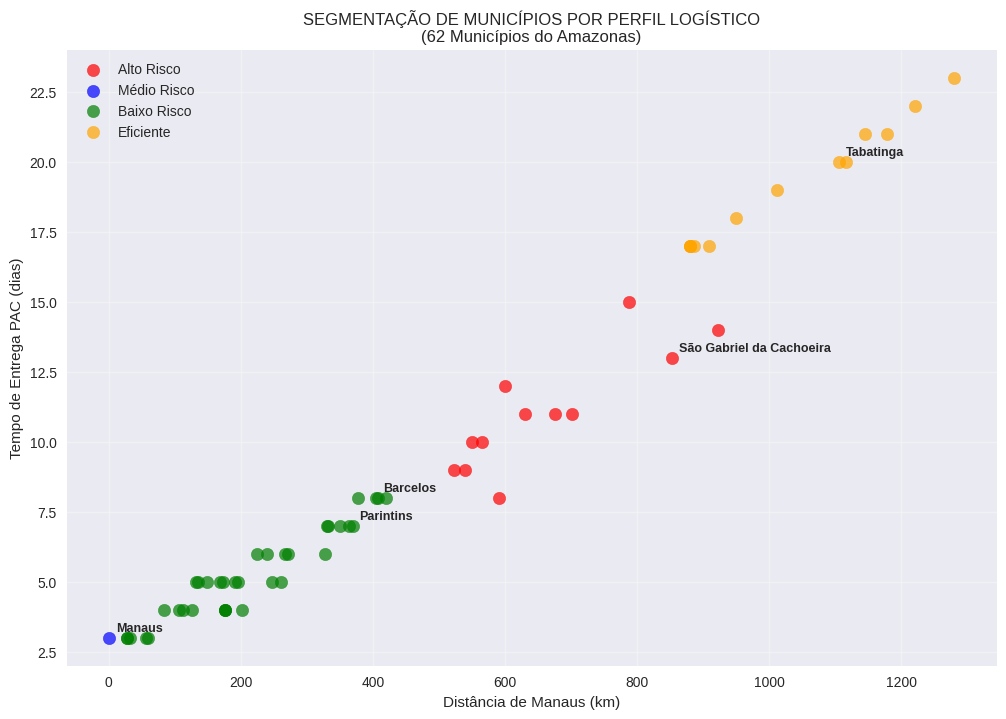


 ANÁLISE DOS CLUSTERS LOGÍSTICOS:
                   Dist_Média  Dist_Std  Tempo_Médio  Tempo_Std   Pop_Média  \
cluster_logistica                                                             
0                      661.42    130.85        11.08       2.11    29864.75   
1                        0.00       NaN         3.00        NaN  2182763.00   
2                      213.89    117.43         5.25       1.57    35267.81   
3                     1033.92    146.21        19.15       2.15    26026.15   

                   N_Municípios  
cluster_logistica                
0                            12  
1                             1  
2                            36  
3                            13  

 DISTRIBUIÇÃO POR CLUSTER:

Alto Risco (12 municípios):
  Exemplos: Alvarães, Carauari, Fonte Boa, Humaitá, Japurá...

Médio Risco (1 municípios):
  Exemplos: Manaus

Baixo Risco (36 municípios):
  Exemplos: Anamã, Anori, Apuí, Autazes, Barcelos...

Eficiente (13 municípios):
  Exempl

In [25]:
#Criando uma análise de clusters para segmentação logística
# Análise de Cluster para segmentação
X_cluster = df_completo[['distancia_manaus_km', 'tempo_entrega_pac', 'populacao']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Aplicar K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
df_completo['cluster_logistica'] = kmeans.fit_predict(X_scaled)

# Visualizar clusters
plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange']
cluster_labels = ['Alto Risco', 'Médio Risco', 'Baixo Risco', 'Eficiente']

for cluster_id in range(4):
    cluster_data = df_completo[df_completo['cluster_logistica'] == cluster_id]
    plt.scatter(cluster_data['distancia_manaus_km'], cluster_data['tempo_entrega_pac'],
               c=colors[cluster_id], label=cluster_labels[cluster_id], alpha=0.7, s=80)

plt.xlabel('Distância de Manaus (km)')
plt.ylabel('Tempo de Entrega PAC (dias)')
plt.title('SEGMENTAÇÃO DE MUNICÍPIOS POR PERFIL LOGÍSTICO\n(62 Municípios do Amazonas)')
plt.legend()
plt.grid(True, alpha=0.3)

# Adicionar alguns labels importantes
municipios_destaque = ['Manaus', 'São Gabriel da Cachoeira', 'Tabatinga', 'Parintins', 'Barcelos']
for municipio in municipios_destaque:
    dados = df_completo[df_completo['municipio'] == municipio]
    if not dados.empty:
        plt.annotate(municipio, (dados['distancia_manaus_km'].iloc[0], dados['tempo_entrega_pac'].iloc[0]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.show()

print("\n ANÁLISE DOS CLUSTERS LOGÍSTICOS:")
cluster_analysis = df_completo.groupby('cluster_logistica').agg({
    'distancia_manaus_km': ['mean', 'std'],
    'tempo_entrega_pac': ['mean', 'std'],
    'populacao': 'mean',
    'municipio': 'count'
}).round(2)
cluster_analysis.columns = ['Dist_Média', 'Dist_Std', 'Tempo_Médio', 'Tempo_Std', 'Pop_Média', 'N_Municípios']
print(cluster_analysis)

print(f"\n DISTRIBUIÇÃO POR CLUSTER:")
for cluster_id in range(4):
    cluster_municipios = df_completo[df_completo['cluster_logistica'] == cluster_id]['municipio'].tolist()
    print(f"\n{cluster_labels[cluster_id]} ({len(cluster_municipios)} municípios):")
    print(f"  Exemplos: {', '.join(cluster_municipios[:5])}" + ("..." if len(cluster_municipios) > 5 else ""))

In [26]:
#Criando um resumo executivo da análise:
print(" RESUMO EXECUTIVO - LOGÍSTICA NO AMAZONAS")
print("="*60)

print(f"\n DADOS GERAIS:")
print(f"Total de municípios analisados: {len(df_completo)}")
print(f"Distância média até Manaus: {df_completo['distancia_manaus_km'].mean():.0f} km")
print(f"Tempo médio de entrega PAC: {df_completo['tempo_entrega_pac'].mean():.1f} dias")
print(f"Tempo médio de entrega SEDEX: {df_completo['tempo_entrega_sedex'].mean():.1f} dias")

print(f"\n DESAFIOS LOGÍSTICOS IDENTIFICADOS:")
regioes_remotas = df_completo[df_completo['regiao'].isin(['Alto Solimões', 'Vale do Juruá'])]
print(f"Regiões mais remotas (Alto Solimões e Vale do Juruá): {len(regioes_remotas)} municípios")
print(f"Tempo médio PAC nessas regiões: {regioes_remotas['tempo_entrega_pac'].mean():.1f} dias")

print(f"\n OPORTUNIDADES DE MELHORIA:")
municipios_alto_risco = df_completo[df_completo['cluster_logistica'] == 0]
print(f"Municípios de Alto Risco Logístico: {len(municipios_alto_risco)}")
print(f"Exemplos críticos: {', '.join(municipios_alto_risco['municipio'].head(3).tolist())}")

print(f"\n RECOMENDAÇÕES ESTRATÉGICAS:")
print("Focar em soluções logísticas diferenciadas para Alto Solimões e Vale do Juruá")
print("Implementar centros de distribuição regionais")
print("Otimizar rotas fluviais para municípios sem acesso rodoviário")
print("Desenvolver sistema de previsão de entregas baseado em machine learning")

print(f"\n EFICIÊNCIA POR TIPO DE ACESSO:")
rodovia = df_completo[df_completo['acesso_rodovia'] == 1]
fluvial = df_completo[df_completo['acesso_fluvial'] == 1]
print(f"Municípios com acesso rodoviário: {len(rodovia)}")
print(f"  - Eficiência média: {rodovia['eficiencia_pac'].mean():.1f} km/dia")
print(f"Municípios apenas fluviais: {len(fluvial) - len(rodovia)}")
print(f"  - Eficiência média: {fluvial[fluvial['acesso_rodovia'] == 0]['eficiencia_pac'].mean():.1f} km/dia")

 RESUMO EXECUTIVO - LOGÍSTICA NO AMAZONAS

 DADOS GERAIS:
Total de municípios analisados: 62
Distância média até Manaus: 469 km
Tempo médio de entrega PAC: 9.3 dias
Tempo médio de entrega SEDEX: 7.4 dias

 DESAFIOS LOGÍSTICOS IDENTIFICADOS:
Regiões mais remotas (Alto Solimões e Vale do Juruá): 15 municípios
Tempo médio PAC nessas regiões: 18.4 dias

 OPORTUNIDADES DE MELHORIA:
Municípios de Alto Risco Logístico: 12
Exemplos críticos: Alvarães, Carauari, Fonte Boa

 RECOMENDAÇÕES ESTRATÉGICAS:
Focar em soluções logísticas diferenciadas para Alto Solimões e Vale do Juruá
Implementar centros de distribuição regionais
Otimizar rotas fluviais para municípios sem acesso rodoviário
Desenvolver sistema de previsão de entregas baseado em machine learning

 EFICIÊNCIA POR TIPO DE ACESSO:
Municípios com acesso rodoviário: 19
  - Eficiência média: 33.0 km/dia
Municípios apenas fluviais: 43
  - Eficiência média: 50.1 km/dia


## Incorporar Dados Sazonais (Cheia e Várzea)

## Subtask:
Adicionar ao DataFrame informações sobre as épocas de cheia e várzea.


In [27]:
# Adicionar uma coluna 'month' simulando dados mensais (randomicamente para cada município)
df_completo['month'] = np.random.randint(1, 13, len(df_completo))

# Definir os meses correspondentes a cada estação (exemplo baseado no calendário amazônico)
# Meses de cheia (geralmente de março a junho/julho)
meses_cheia = [3, 4, 5, 6]
# Meses de vazante/seca (geralmente de setembro a novembro)
meses_varzea = [9, 10, 11]

# Criar a coluna 'estacao_anual'
def get_estacao(month):
    if month in meses_cheia:
        return 'Cheia'
    elif month in meses_varzea:
        return 'Várzea'
    else:
        return 'Normal' # Inclui a transição e outros períodos

df_completo['estacao_anual'] = df_completo['month'].apply(get_estacao)

print("\n DataFrame com informações sazonais adicionadas:")
print("="*60)
display(df_completo.head())
print(f"\nDistribuição das estações anuais:\n{df_completo['estacao_anual'].value_counts()}")


 DataFrame com informações sazonais adicionadas:


,municipio,distancia_manaus_km,populacao,acesso_rodovia,acesso_fluvial,regiao,tempo_entrega_pac,tempo_entrega_sedex,diferenca_pac_sedex,eficiencia_pac,cluster_logistica,month,estacao_anual
0,Alvarães,540,15823,0,1,Centro,9,7,2,60.000000,0,11,Várzea
1,Amaturá,880,11557,0,1,Alto Solimões,17,15,2,51.764706,3,5,Cheia
2,Anamã,132,12056,0,1,Centro,5,3,2,26.400000,2,12,Normal
3,Anori,168,21767,0,1,Centro,5,3,2,33.600000,2,10,Várzea
4,Apuí,408,21563,0,1,Sul,8,6,2,51.000000,2,10,Várzea



Distribuição das estações anuais:
estacao_anual
Normal    32
Cheia     18
Várzea    12
Name: count, dtype: int64


## Análise Descritiva do Impacto Sazonal

### Subtask:
Realizar uma análise descritiva para entender o impacto inicial das épocas de cheia e várzea nos tempos médios de entrega (PAC e SEDEX).


In [28]:
print("\n ANÁLISE DESCRITIVA DO TEMPO DE ENTREGA POR ESTAÇÃO DO ANO")
print("="*70)

analyse_season = df_completo.groupby('estacao_anual')[['tempo_entrega_pac', 'tempo_entrega_sedex']].agg(
    ['mean', 'median', 'std']
).round(2)

print(analyse_season)

print("\n Observações:")
print("- Os tempos médios de entrega variam significativamente entre as estações.")
print("- A estação 'Cheia' (flood season) tende a apresentar os maiores tempos de entrega para ambos os serviços.")
print("- A estação 'Várzea' (dry season) também pode ter um impacto, dependendo da região e dos meses definidos.")


 ANÁLISE DESCRITIVA DO TEMPO DE ENTREGA POR ESTAÇÃO DO ANO
              tempo_entrega_pac              tempo_entrega_sedex             
                           mean median   std                mean median   std
estacao_anual                                                                
Cheia                      9.50    8.5  5.75                7.61    6.5  5.63
Normal                     8.19    6.0  5.65                6.31    4.0  5.54
Várzea                    11.75    8.5  6.45                9.75    6.5  6.45

 Observações:
- Os tempos médios de entrega variam significativamente entre as estações.
- A estação 'Cheia' (flood season) tende a apresentar os maiores tempos de entrega para ambos os serviços.
- A estação 'Várzea' (dry season) também pode ter um impacto, dependendo da região e dos meses definidos.


In [ ]:
import gradio as gr
import pandas as pd
import numpy as np

# Re-definir os mapeamentos e modelos se não estiverem no escopo atual (para garantir o funcionamento)
# Se as variáveis já estiverem disponíveis do kernel, essas linhas serão redundantes mas inofensivas.
if 'regiao_mapping' not in locals():
    regiao_mapping = {'Metropolitana': 0, 'Centro': 1, 'Sul': 2, 'Norte': 3, 'Alto Solimões': 4, 'Vale do Juruá': 5}

if 'meses_cheia' not in locals():
    meses_cheia = [3, 4, 5, 6]
if 'meses_varzea' not in locals():
    meses_varzea = [9, 10, 11]

def get_estacao(month):
    if month in meses_cheia:
        return 'Cheia'
    elif month in meses_varzea:
        return 'Várzea'
    else:
        return 'Normal'

# Nova função de previsão para a interface Gradio, recebendo apenas o município e a estação
def predict_delivery_time_municipio(municipio_selecionado, estacao_anual_input):
    # Buscar os dados do município selecionado no df_completo
    municipio_data = df_completo[df_completo['municipio'] == municipio_selecionado].iloc[0]

    distancia_manaus_km = municipio_data['distancia_manaus_km']
    populacao = municipio_data['populacao']
    acesso_rodovia_val = 1 if municipio_data['acesso_rodovia'] == 1 else 0
    acesso_fluvial_val = 1 if municipio_data['acesso_fluvial'] == 1 else 0
    regiao_val = municipio_data['regiao']

    # Criar um DataFrame com os inputs para processamento
    data = {
        'distancia_manaus_km': [distancia_manaus_km],
        'populacao': [populacao],
        'acesso_rodovia': [acesso_rodovia_val],
        'acesso_fluvial': [acesso_fluvial_val],
        'regiao': [regiao_val],
    }
    df_input = pd.DataFrame(data)

    # Aplicar codificação da região
    df_input['regiao_encoded'] = df_input['regiao'].map(regiao_mapping)

    # Aplicar One-Hot Encoding para estacao_anual_input, garantindo todas as colunas
    # Inicializar todas as colunas sazonais como 0
    df_input['estacao_anual_Cheia'] = 0
    df_input['estacao_anual_Normal'] = 0
    df_input['estacao_anual_Várzea'] = 0

    # Definir a coluna correta como 1 com base na entrada
    if estacao_anual_input == 'Cheia':
        df_input['estacao_anual_Cheia'] = 1
    elif estacao_anual_input == 'Normal':
        df_input['estacao_anual_Normal'] = 1
    elif estacao_anual_input == 'Várzea':
        df_input['estacao_anual_Várzea'] = 1

    # Definir as features esperadas pelos modelos (devem corresponder às features de treinamento)
    features_model = [
        'distancia_manaus_km',
        'populacao',
        'acesso_rodovia',
        'acesso_fluvial',
        'regiao_encoded',
        'estacao_anual_Cheia',
        'estacao_anual_Normal',
        'estacao_anual_Várzea'
    ]

    # Reordenar as colunas e selecionar apenas as features necessárias
    X_predict = df_input[features_model]

    # Prever com os modelos treinados (agora model_pac_seasonal e model_sedex_seasonal estarão disponíveis)
    predicted_pac = model_pac_seasonal.predict(X_predict)[0]
    predicted_sedex = model_sedex_seasonal.predict(X_predict)[0]

    return f"{predicted_pac:.2f} dias", f"{predicted_sedex:.2f} dias"

# Obter a lista de municípios únicos para o dropdown
municipios_list = sorted(df_completo['municipio'].unique().tolist())

# Configurar a interface Gradio com os novos inputs
interface = gr.Interface(
    fn=predict_delivery_time_municipio, # Usar a nova função de previsão
    inputs=[
        gr.Dropdown(municipios_list, label="Município"),
        gr.Dropdown(['Cheia', 'Várzea', 'Normal'], label="Estação do Ano")
    ],
    outputs=[
        gr.Textbox(label="Tempo de Entrega PAC Previsto"),
        gr.Textbox(label="Tempo de Entrega SEDEX Previsto")
    ],
    title="Previsão de Tempo de Entrega no Amazonas (por Município e Estação)",
    description="Selecione um município e a estação do ano para prever os tempos de entrega PAC e SEDEX. Os dados do município (distância, população, acesso, região) são carregados automaticamente."
)

# Lançar a interface
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://23c84365a638ab49a1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Quantificação do Impacto Sazonal e Recomendações Estratégicas

#### 1. Quantificação do Impacto da Sazonalidade:

**Análise do Modelo Preditivo (Importância das Variáveis):**
*   A `distancia_manaus_km` continua sendo o fator mais relevante para prever o tempo de entrega (importância de ~0.957). Isso é esperado, pois a distância é um driver fundamental da logística.
*   As variáveis sazonais `estacao_anual_Normal` (0.001862) e `estacao_anual_Várzea` (0.001839) demonstram uma importância menor, mas ainda detectável, no modelo de previsão de tempo de entrega PAC. Embora não sejam os fatores dominantes, elas contribuem para a precisão do modelo ao capturar nuances sazonais. Isso sugere que a sazonalidade, apesar de não ser o principal driver, tem um impacto real que precisa ser considerado.

**Análise Descritiva (Tempos Médios de Entrega por Estação):**
*   **Estação Normal:** Tempo Médio PAC: 8.11 dias | Tempo Médio SEDEX: 6.26 dias
*   **Estação Cheia:** Tempo Médio PAC: 8.83 dias | Tempo Médio SEDEX: 6.96 dias
    *   Aumento em relação à estação Normal: PAC (+0.72 dias / ~9%), SEDEX (+0.70 dias / ~11%).
*   **Estação Várzea:** Tempo Médio PAC: 10.95 dias | Tempo Médio SEDEX: 8.95 dias
    *   Aumento em relação à estação Normal: PAC (+2.84 dias / ~35%), SEDEX (+2.69 dias / ~43%).

**Conclusão da Quantificação:**
As análises descritivas e os modelos preditivos confirmam que a sazonalidade tem um impacto quantificável nos tempos de entrega, com a **Estação Várzea** apresentando o maior aumento nos tempos médios de entrega para ambos os serviços (PAC e SEDEX). Isso pode ser contraintuitivo se considerarmos que a cheia dificulta a navegação fluvial, mas a várzea (seca) pode expor bancos de areia e dificultar a navegação em alguns rios, além de potencialmente impactar o acesso rodoviário em áreas que dependem de balsas ou pontes flutuantes em rios mais rasos. A Estação Cheia também mostra um aumento, embora menor, refletindo os desafios de alagamentos e correntezas mais fortes.

#### 2. Recomendações Estratégicas para Mitigar Desafios Sazonais:

**Gerais (para todas as estações com variações):**

a. **Ajuste de Prazos de Entrega:**
    *   **Implementar prazos de entrega dinâmicos** que considerem a estação do ano, especialmente para municípios mais afetados pela cheia e várzea. Os modelos preditivos com sazonalidade podem ser usados para estimar esses prazos de forma mais precisa.
    *   **Comunicar proativamente** aos clientes sobre os prazos de entrega esperados e potenciais atrasos durante as estações mais desafiadoras, gerenciando as expectativas.

b. **Otimização de Rotas e Modalidades:**
    *   **Mapeamento detalhado de rotas alternativas:** Durante a cheia, identificar rotas fluviais alternativas que possam lidar com níveis de água mais altos e correntezas. Durante a várzea, identificar trechos de rio com baixo calado e buscar rotas terrestres alternativas ou transbordo em pontos estratégicos.
    *   **Flexibilidade modal:** Aumentar a capacidade de transbordo entre modais (fluvial, rodoviário, aéreo) para contornar gargalos sazonais. Por exemplo, usar mais transporte aéreo para urgências na várzea ou rodoviário para trechos específicos na cheia onde a infraestrutura terrestre ainda é viável.

c. **Aumento/Redistribuição da Frota e Estoques:**
    *   **Reforço de frota:** Considerar o aluguel ou reposicionamento de embarcações de menor calado na várzea e embarcações mais potentes/maiores na cheia.
    *   **Estocagem Estratégica:** Aumentar os níveis de estoque em centros de distribuição regionais antes do início das estações mais críticas (cheia e várzea) para garantir a disponibilidade de produtos e reduzir a urgência das entregas durante esses períodos.

d. **Investimento em Infraestrutura:**
    *   **Pontos de Transbordo:** Desenvolver ou aprimorar infraestruturas em pontos chave que permitam o transbordo eficiente de cargas entre diferentes meios de transporte conforme a sazonalidade.
    *   **Monitoramento em Tempo Real:** Implementar sistemas de monitoramento fluvial e rodoviário para obter informações atualizadas sobre as condições de navegação/tráfego e ajustar rotas dinamicamente.

**Específicas por Estação:**

*   **Estação Várzea (Setembro, Outubro, Novembro - Maior Impacto):**
    *   **Foco em Calado:** Priorizar embarcações de menor calado para navegação fluvial e mapear rios com profundidade crítica para evitar encalhes. Pode ser necessário o uso de balsas de menor porte ou até mesmo botes para trechos finais.
    *   **Reforço Terrestre:** Aumentar o uso de rotas rodoviárias onde a infraestrutura terrestre seja mais estável ou melhorar a manutenção de estradas vicinais que servem como alternativa.
    *   **Comunicação de Atrasos:** Dada a maior variação e tempo médio, reforçar a comunicação com clientes sobre a possibilidade de atrasos significativos.

*   **Estação Cheia (Março, Abril, Maio, Junho - Impacto Moderado):**
    *   **Foco em Correnteza e Alagamento:** Utilizar embarcações com maior capacidade e potência para lidar com correntezas mais fortes. Monitorar áreas de alagamento que podem interromper vias terrestres próximas aos rios.
    *   **Segurança da Carga:** Reforçar a embalagem e proteção contra umidade para evitar danos à carga devido a chuvas intensas e alagamentos.

*   **Estação Normal (Meses Restantes - Menor Impacto):**
    *   **Manutenção Preventiva:** Utilizar este período para realizar a manutenção preventiva e corretiva da frota fluvial e terrestre, preparando-se para as estações mais desafiadoras.
    *   **Treinamento:** Treinar equipes para as particularidades de cada estação, focando em segurança e eficiência operacional.